In [1]:
#Compares histograms of input and output spike rates
res_folder = '../output_sim_DG_2/' #to load results from
neuron_file = 'neuron_list1' #to load neuron data from
inp_spike_file = 'spike_trains_DG_L4_NR'  #to load spikes from
L23_spike_file = 'spike_trains_DG_L23_NR'  #to load spikes from

plot_spikes = True

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import ranksums
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#load neuron list
nrn_list = pd.DataFrame.from_csv('../build/' + neuron_file + '.csv', sep=' ')
idx_E = np.where(nrn_list.type=='LIF_exc')[0]
idx_I = np.where(nrn_list.type=='LIF_inh')[0]
nrn_type = np.zeros((len(nrn_list))).astype(int)
nrn_type[idx_E] = 1
nrn_type[idx_I] = 2
num_cells = len(nrn_list)

In [4]:
#load output spike data
spike_data = pd.read_csv(res_folder + 'spk.dat', sep=' ', header=None, names=['t', 'id'])
spike_times = []
for k in range(num_cells):
    spike_times_tmp = list(1e-3*spike_data.t[spike_data.id==k].values) #convert (ms) to (s)
    spike_times.append(spike_times_tmp)

In [5]:
#compute mean rates
signal_length = 1e-3*max(spike_data.t) #(s)
firing_rates = [1.0*len(spike_times[k])/signal_length for k in range(len(spike_times))] #compute single-cell firing rates
num_spikes = np.sum([len(spike_times[k]) for k in range(len(spike_times))]) #total number of spikes
num_spikes_E = np.sum([len(spike_times[k]) for k in idx_E])
num_spikes_I = np.sum([len(spike_times[k]) for k in idx_I])
mean_rate = 1.0*num_spikes/(signal_length*num_cells)
pop_rate = 1.0*num_spikes/(signal_length)
mean_rate_E = 1.0*num_spikes_E/(signal_length*len(idx_E))
mean_rate_I = 1.0*num_spikes_I/(signal_length*len(idx_I))
print('Signal length: %.2fs'%(signal_length))
print('Mean firing rate: %.2fHz'%(mean_rate))
print('Mean E firing rate: %.2fHz'%(mean_rate_E))
print('Mean I firing rate: %.2fHz'%(mean_rate_I))
print('Population firing rate: %.2fHz'%(pop_rate))

Signal length: 143.97s
Mean firing rate: 0.45Hz
Mean E firing rate: 0.23Hz
Mean I firing rate: 1.31Hz
Population firing rate: 223.89Hz


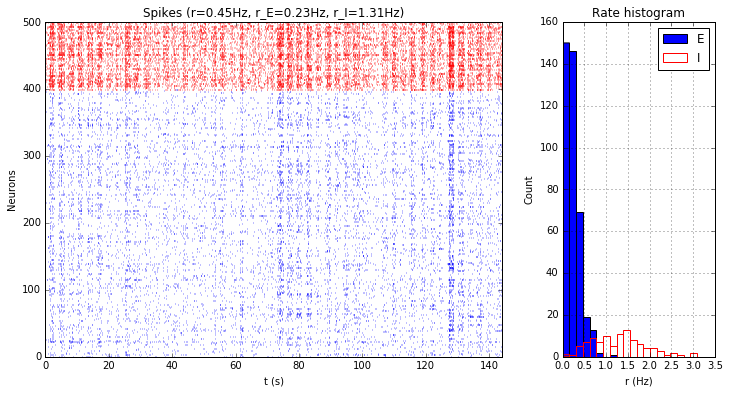

In [6]:
#plot spikes
if plot_spikes:
    ch_max = num_cells #max. number of channels to plot
    nrn_colors = ['k', 'b', 'r'] #undefined/excitatory/inhibitory
    fig, ax = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [3, 1]})
    for n in range(min(num_cells, ch_max)):
        ax[0].plot(spike_times[n], (n + 1)*np.ones_like(spike_times[n]), '|'+nrn_colors[nrn_type[n]], markersize=1)
        #ax[0].plot([spike_times[n], spike_times[n]], [(0.5+n)*np.ones_like(spike_times[n]), (1.5+n)*np.ones_like(spike_times[n])], nrn_colors[nrn_type[n]])
    ax[0].set_xlim((0, signal_length))
    #ax[0].set_xlim((0, 10))
    ax[0].set_ylim((0.5, min(num_cells, ch_max)+0.5))
    ax[0].set_xlabel('t (s)')
    ax[0].set_ylabel('Neurons')
    ax[0].set_title('Spikes (r=%.2fHz, r_E=%.2fHz, r_I=%.2fHz)'%(mean_rate, mean_rate_E, mean_rate_I))
    ax[1].hist(np.array(firing_rates)[idx_E], 20, range=(0, max(firing_rates)), color=nrn_colors[1], label='E')
    ax[1].hist(np.array(firing_rates)[idx_I], 20, range=(0, max(firing_rates)), edgecolor=nrn_colors[2], facecolor='none', label='I')
    ax[1].set_xlabel('r (Hz)')
    ax[1].set_ylabel('Count')
    ax[1].set_title('Rate histogram')
    ax[1].grid(True)
    ax[1].legend()
    #ax[1].hist(np.array(ISI_list), 20)
    #ax[1].set_xlabel('ISI (s)')
    #ax[1].set_title('ISI histogram')
    #ax[1].grid(True)
    fig.savefig(res_folder + 'output_spikes.png', dpi=600)

In [7]:
#load input spikes from file
filter_inp_spikes = True #filter to signal_length (optional)
f = open('../input_spike_trains/' + inp_spike_file + '.dat', 'r')
inp_spikes = f.readlines()
f.close()
inp_spike_times = []
for n in range(len(inp_spikes)):
    inp_spike_train = inp_spikes[n][1:-2].split(' ')
    if len(inp_spike_train[0])>0:
        inp_spike_train = [1e-3*float(inp_spike_train[k]) for k in range(len(inp_spike_train))] #convert to (s)
    else:
        inp_spike_train = []
    if filter_inp_spikes:
        inp_spike_train = list(np.array(inp_spike_train)[inp_spike_train<=signal_length])
    inp_spike_times.append(inp_spike_train)
inp_signal_length = max([max(inp_spike_times[k]) if len(inp_spike_times[k])>0 else 0 for k in range(len(inp_spike_times))])
num_inputs = len(inp_spikes)
inp_firing_rates = [1.0*len(inp_spike_times[k])/inp_signal_length for k in range(len(inp_spike_times))] #compute single-cell firing rates
inp_num_spikes = np.sum([len(inp_spike_times[k]) for k in range(len(inp_spike_times))])  #total number of spikes
inp_mean_rate = 1.0*inp_num_spikes/(inp_signal_length*num_inputs)

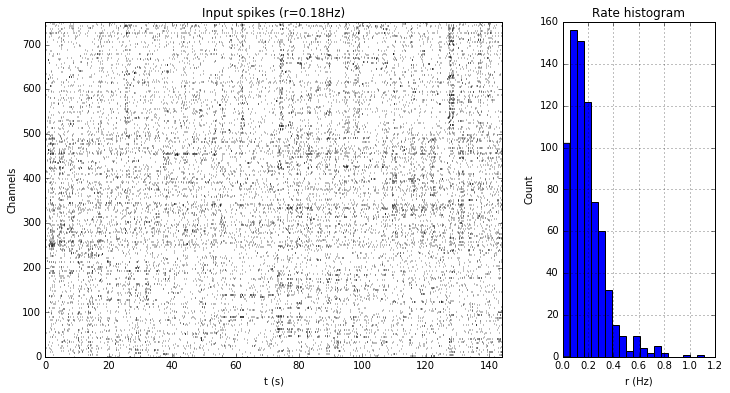

In [8]:
if plot_spikes:
    #plot spikes
    ch_max = num_inputs #max. number of channels to plot
    fig, ax = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [3, 1]})
    for n in range(min(num_inputs, ch_max)):
        ax[0].plot(inp_spike_times[n], (n + 1)*np.ones_like(inp_spike_times[n]), '|k', markersize=1)
        #ax[0].plot([inp_spike_times[n], inp_spike_times[n]], [(0.5+n)*np.ones_like(inp_spike_times[n]), (1.5+n)*np.ones_like(inp_spike_times[n])], 'k')
    ax[0].set_xlim((0, inp_signal_length))
    #ax[0].set_xlim((0, 10))
    ax[0].set_ylim((0.5, min(num_inputs, ch_max)+0.5))
    ax[0].set_xlabel('t (s)')
    ax[0].set_ylabel('Channels')
    ax[0].set_title('Input spikes (r=%.2fHz)'%(inp_mean_rate))
    ax[1].hist(np.array(inp_firing_rates), 20)
    ax[1].set_xlabel('r (Hz)')
    ax[1].set_ylabel('Count')
    ax[1].set_title('Rate histogram')
    ax[1].grid(True)
    fig.savefig(res_folder + 'input_spikes.png', dpi=600)

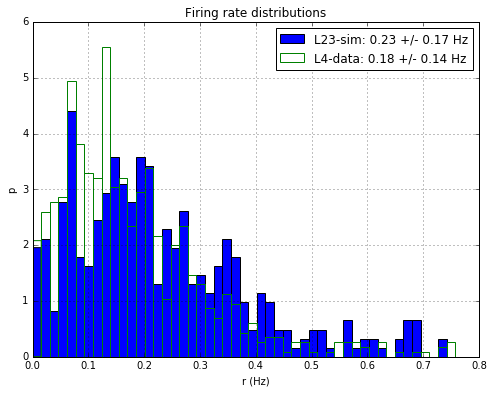

In [9]:
#comparison of rate histograms
n_bins = 50
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(np.array(firing_rates)[idx_E], n_bins, normed=True, range=(0, 0.25*max(max(firing_rates), max(inp_firing_rates))), color=nrn_colors[1], label='L23-sim: %.2f +/- %.2f Hz'%(np.mean(np.array(firing_rates)[idx_E]), np.std(np.array(firing_rates)[idx_E])))
ax.hist(np.array(inp_firing_rates), n_bins, normed=True, range=(0, 0.25*max(max(firing_rates), max(inp_firing_rates))), edgecolor='g', facecolor='none', label='L4-data: %.2f +/- %.2f Hz'%(np.mean(np.array(inp_firing_rates)[idx_E]), np.std(np.array(inp_firing_rates)[idx_E])))
ax.set_xlabel('r (Hz)')
ax.set_ylabel('p')
ax.set_title('Firing rate distributions')
ax.grid(True)
ax.legend()
fig.savefig(res_folder + 'output_vs_input_spikes.png', dpi=600)

In [10]:
#load L2/3 spikes from file
filter_L23_spikes = True #filter to signal_length (optional)
f = open('../input_spike_trains/' + L23_spike_file + '.dat', 'r')
L23_spikes = f.readlines()
f.close()
L23_spike_times = []
for n in range(len(L23_spikes)):
    L23_spike_train = L23_spikes[n][1:-2].split(' ')
    if len(L23_spike_train[0])>0:
        L23_spike_train = [1e-3*float(L23_spike_train[k]) for k in range(len(L23_spike_train))] #convert to (s)
    else:
        L23_spike_train = []
    if filter_L23_spikes:
        L23_spike_train = list(np.array(L23_spike_train)[L23_spike_train<=signal_length])
    L23_spike_times.append(L23_spike_train)
L23_signal_length = max([max(L23_spike_times[k]) if len(L23_spike_times[k])>0 else 0 for k in range(len(L23_spike_times))])
num_L23_cells = len(L23_spikes)
L23_firing_rates = [1.0*len(L23_spike_times[k])/L23_signal_length for k in range(num_L23_cells)] #compute single-cell firing rates
L23_num_spikes = np.sum([len(L23_spike_times[k]) for k in range(len(L23_spike_times))])  #total number of spikes
L23_mean_rate = 1.0*L23_num_spikes/(L23_signal_length*num_L23_cells)

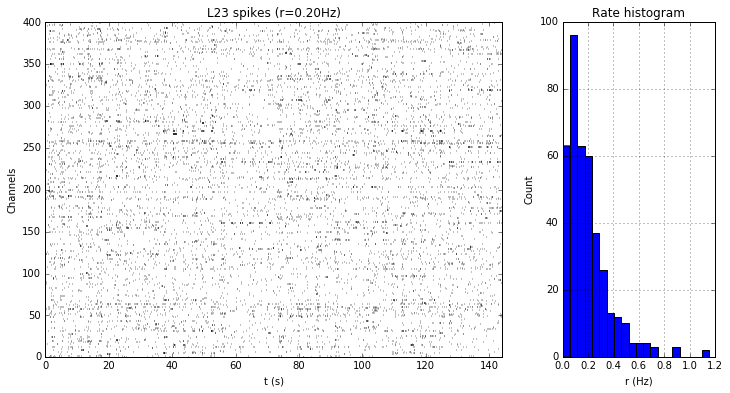

In [11]:
if plot_spikes:
    #plot spikes
    ch_max = num_L23_cells #max. number of channels to plot
    fig, ax = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [3, 1]})
    for n in range(min(num_L23_cells, ch_max)):
        ax[0].plot(L23_spike_times[n], (n + 1)*np.ones_like(L23_spike_times[n]), '|k', markersize=1)
        #ax[0].plot([L23_spike_times[n], L23_spike_times[n]], [(0.5+n)*np.ones_like(L23_spike_times[n]), (1.5+n)*np.ones_like(L23_spike_times[n])], 'k')
    ax[0].set_xlim((0, L23_signal_length))
    #ax[0].set_xlim((0, 10))
    ax[0].set_ylim((0.5, min(num_L23_cells, ch_max)+0.5))
    ax[0].set_xlabel('t (s)')
    ax[0].set_ylabel('Channels')
    ax[0].set_title('L23 spikes (r=%.2fHz)'%(L23_mean_rate))
    ax[1].hist(np.array(L23_firing_rates), 20)
    ax[1].set_xlabel('r (Hz)')
    ax[1].set_ylabel('Count')
    ax[1].set_title('Rate histogram')
    ax[1].grid(True)
    fig.savefig(res_folder + 'L23_spikes.png', dpi=600)

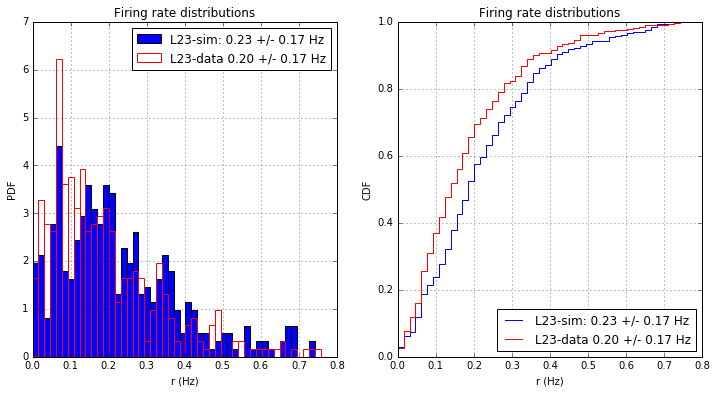

In [12]:
#comparison of rate histograms
n_bins = 50
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].hist(np.array(firing_rates)[idx_E], n_bins, normed=True, range=(0, 0.25*max(max(firing_rates), max(L23_firing_rates))), color=nrn_colors[1], label='L23-sim: %.2f +/- %.2f Hz'%(np.mean(np.array(firing_rates)[idx_E]), np.std(np.array(firing_rates)[idx_E])))
ax[0].hist(np.array(L23_firing_rates), n_bins, normed=True, range=(0, 0.25*max(max(firing_rates), max(L23_firing_rates))), edgecolor='r', facecolor='none', label='L23-data %.2f +/- %.2f Hz'%(np.mean(np.array(L23_firing_rates)[idx_E]), np.std(np.array(L23_firing_rates)[idx_E])))
ax[0].set_xlabel('r (Hz)')
ax[0].set_ylabel('PDF')
ax[0].set_title('Firing rate distributions')
ax[0].grid(True)
ax[0].legend()
hist1, bins1 = np.histogram(np.array(firing_rates)[idx_E], n_bins, density=True, range=(0, 0.25*max(max(firing_rates), max(L23_firing_rates))))
hist2, bins2 = np.histogram(np.array(L23_firing_rates), n_bins, density=True, range=(0, 0.25*max(max(firing_rates), max(L23_firing_rates))))
ax[1].step(bins1, np.cumsum(list(np.diff(bins1)[0]*hist1)+[0]), where='post', color=nrn_colors[1], label='L23-sim: %.2f +/- %.2f Hz'%(np.mean(np.array(firing_rates)[idx_E]), np.std(np.array(firing_rates)[idx_E])))
ax[1].step(bins2, np.cumsum(list(np.diff(bins1)[0]*hist2)+[0]), where='post', color='r', label='L23-data %.2f +/- %.2f Hz'%(np.mean(np.array(L23_firing_rates)[idx_E]), np.std(np.array(L23_firing_rates)[idx_E])))
ax[1].set_xlabel('r (Hz)')
ax[1].set_ylabel('CDF')
ax[1].set_ylim((0, 1))
ax[1].set_title('Firing rate distributions')
ax[1].grid(True)
ax[1].legend(loc='lower right')
fig.savefig(res_folder + 'output_vs_L23_spikes.png', dpi=600)

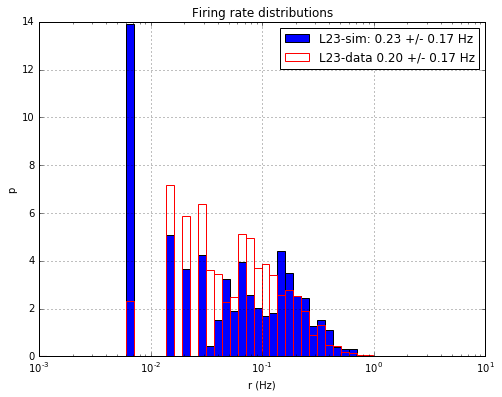

In [13]:
#comparison of rate histograms (log x-axis)
n_bins = 50
log_bins = np.logspace(np.log10(1e-3), np.log10(max(max(firing_rates), max(L23_firing_rates))), n_bins)
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(np.array(firing_rates)[idx_E], log_bins, normed=True, color=nrn_colors[1], label='L23-sim: %.2f +/- %.2f Hz'%(np.mean(np.array(firing_rates)[idx_E]), np.std(np.array(firing_rates)[idx_E])))
ax.hist(np.array(L23_firing_rates), log_bins, normed=True, edgecolor='r', facecolor='none', label='L23-data %.2f +/- %.2f Hz'%(np.mean(np.array(L23_firing_rates)[idx_E]), np.std(np.array(L23_firing_rates)[idx_E])))
ax.set_xscale('log')
ax.set_xlabel('r (Hz)')
ax.set_ylabel('p')
ax.set_title('Firing rate distributions')
ax.grid(True)
ax.legend()
fig.savefig(res_folder + 'output_vs_L23_spikes_log.png', dpi=600)

In [14]:
print('Input rates: %.2f +/- %.2f Hz'%(np.mean(inp_firing_rates), np.std(inp_firing_rates)))
print('E rates: %.2f +/- %.2f Hz'%(np.mean(np.array(firing_rates)[idx_E]), np.std(np.array(firing_rates)[idx_E])))
print('L23 rates: %.2f +/- %.2f Hz'%(np.mean(L23_firing_rates), np.std(L23_firing_rates)))

Input rates: 0.18 +/- 0.14 Hz
E rates: 0.23 +/- 0.17 Hz
L23 rates: 0.20 +/- 0.17 Hz


In [15]:
rate_th = 0.01
print('%d silent E neurons in network'%(np.sum(np.array(firing_rates)[idx_E]<rate_th)))
print('%d silent E neurons in L23 data'%(np.sum(np.array(L23_firing_rates)<rate_th)))

7 silent E neurons in network
3 silent E neurons in L23 data


In [16]:
alpha = 0.01
p = ranksums(firing_rates, L23_firing_rates)[1]
print('Firing rate distributions %ssignificantly different (p=%g)'%('' if p<alpha else 'not ', p))

Firing rate distributions significantly different (p=1.07894e-15)
